In [1]:
!pip install nvcc4jupyter
!apt-get update -qq
!apt-get install -y libpng-dev git unzip wget
!nvcc --version


W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libpng-dev is already the newest version (1.6.37-3build5).
git is already the newest version (1:2.34.1-1ubuntu1.15).
unzip is already the newest version (6.0-26ubuntu3.2).
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 43 not upgraded.
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


In [2]:
!rm -rf Paralela-proj3
!git clone --depth 1 https://github.com/DanielRasho/Paralela-proj3


Cloning into 'Paralela-proj3'...
remote: Enumerating objects: 14, done.
remote: Counting objects: 100% (14/14), done.
remote: Compressing objects: 100% (14/14), done.
remote: Total 14 (delta 3), reused 6 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (14/14), 1.72 MiB | 5.51 MiB/s, done.
Resolving deltas: 100% (3/3), done.


In [3]:
import subprocess

gpu_info = subprocess.getoutput(
    "nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits"
)
if "not found" in gpu_info.lower():
    raise RuntimeError("Error: No GPU found. Please select GPU runtime in Colab.")

gpu_name, compute_cap = map(str.strip, gpu_info.split(","))
gpu_arch = f"sm_{compute_cap.replace('.', '')}"

print(f"{'GPU Name':<15}: {gpu_name}")
print(f"{'Architecture':<15}: {gpu_arch}")


GPU Name       : Tesla T4
Architecture   : sm_75


In [4]:
!rm -rf ./media
!git clone --depth 1 https://github.com/opencv/opencv.git
!mkdir -p ./media/raw ./media/pgm ./media/output
!cp -r opencv/samples/data/* ./media/raw
!rm -rf opencv ./media/raw/aruco ./media/raw/dnn


Cloning into 'opencv'...
remote: Enumerating objects: 9128, done.
remote: Counting objects: 100% (9128/9128), done.
remote: Compressing objects: 100% (7797/7797), done.
remote: Total 9128 (delta 1430), reused 4700 (delta 892), pack-reused 0 (from 0)
Receiving objects: 100% (9128/9128), 89.54 MiB | 12.34 MiB/s, done.
Resolving deltas: 100% (1430/1430), done.
Updating files: 100% (7666/7666), done.


In [5]:
import cv2
from pathlib import Path

input_dir = Path("./media/raw")
output_dir = Path("./media/pgm")
output_dir.mkdir(parents=True, exist_ok=True)

LOW_THRESH, HIGH_THRESH = 100, 200
files = [f for f in input_dir.iterdir() if f.suffix.lower() in [".png", ".jpg", ".jpeg"]]

for i, file in enumerate(sorted(files)):
    img = cv2.imread(str(file), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Could not read {file}, skipping.")
        continue

    blur = cv2.GaussianBlur(img, (3, 3), 0)
    edges = cv2.Canny(blur, LOW_THRESH, HIGH_THRESH)
    output_path = output_dir / f"{i}.pgm"
    cv2.imwrite(str(output_path), edges)

print("Finished processing all PNG/JPG images.")


Finished processing all PNG/JPG images.


In [6]:
# Versión CPU
!nvcc -o main ./Paralela-proj3/src/cpu.cu $(pkg-config --cflags --libs libpng)
!./main ./Paralela-proj3/media/runway.pgm ./media/output/0.png



==== CPU-Only Hough Transform ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Processing Hough Transform...
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200

Processed 138406 edge pixels

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.2217 rad), r=-145.00, votes=2189
Line 6: theta=72.00 deg (1.2566 rad), r=-145.00, votes=2128
Line 7: theta=108.00 deg (1.8850 rad), r=-145.00, votes=2166
Line 8: theta=110.00 deg (1.9199 rad), r=-145.00, votes=2166
Line 9: theta=112.00 deg (1.9548 rad), r=-145.00, votes=2170
Line 10: t

In [7]:
# Versión con memoria Global
!nvcc -arch=sm_75 -o global ./Paralela-proj3/src/globa.cu $(pkg-config --cflags --libs libpng)
!./global ./Paralela-proj3/media/runway.pgm ./media/output/0-global.png


==== CUDA Hough Transform (Global Memory) ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0-global.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Hough Transform Parameters:
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200
  Accumulator size = 18000 bins

CUDA Kernel Configuration:
  Block size: 256 threads
  Grid size: 1875 blocks
  Total threads: 480000

Launching kernel...
Kernel completed!

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.2217 rad), r=-145.00, votes=2189
Line 6: theta=72.00 deg (1.2566 rad), r=-145.00, votes=2128
Line 7: theta=108.00 deg (1.8850

In [8]:
# Versión con memoria Constante
!nvcc -arch=sm_75 -o constant ./Paralela-proj3/src/constant.cu $(pkg-config --cflags --libs libpng)
!./constant ./Paralela-proj3/media/runway.pgm ./media/output/0-constant.png


==== CUDA Hough Transform (CONSTANT Memory) ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0-constant.png
Threshold: 2100 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Hough Transform Parameters:
  rMax = 500.00
  rScale = 5.00
  degreeBins = 90
  rBins = 200
  Accumulator size = 18000 bins

Memory Configuration:
  Using CONSTANT memory for d_Cos and d_Sin (90 floats each)
  Constant memory used: 720 bytes

CUDA Kernel Configuration:
  Block size: 256 threads
  Grid size: 1875 blocks
  Total threads: 480000

Launching kernel...
Kernel completed!

==== Detected Lines (threshold = 2100 votes) ====
Line 0: theta=110.00 deg (1.9199 rad), r=-155.00, votes=2151
Line 1: theta=106.00 deg (1.8500 rad), r=-150.00, votes=2123
Line 2: theta=108.00 deg (1.8850 rad), r=-150.00, votes=2107
Line 3: theta=110.00 deg (1.9199 rad), r=-150.00, votes=2157
Line 4: theta=112.00 deg (1.9548 rad), r=-150.00, votes=2114
Line 5: theta=70.00 deg (1.221

In [9]:
# Versión con memoria Compartida
!nvcc -arch=sm_75 -o shared ./Paralela-proj3/src/shared.cu $(pkg-config --cflags --libs libpng)
!./shared ./Paralela-proj3/media/runway.pgm ./media/output/0-shared.png


==== CUDA Hough Transform (SHARED + CONSTANT Memory) ====
Input image: ./Paralela-proj3/media/runway.pgm
Output image: ./media/output/0-shared.png
Threshold: 3000 votes

Image dimensions: 800 x 600
Edge pixels detected: 138406 (28.83%)

Hough Transform Parameters:
  rMax = 500.00
  rScale = 7.35
  degreeBins = 90
  rBins = 136
  Accumulator size = 12240 bins

Memory Configuration:
  Using CONSTANT memory for d_Cos and d_Sin (90 floats each)
  Constant memory used: 720 bytes
  Using SHARED memory for local accumulator
  Shared memory per block: 48960 bytes (47.81 KB)

CUDA Kernel Configuration:
  Block size: 256 threads
  Grid size: 1875 blocks
  Total threads: 480000

Launching kernel...
Kernel execution time: 2.336 ms

Kernel completed!

==== Accumulator Statistics ====
Max votes in any bin: 4215
Non-zero bins: 10951 / 12240 (89.47%)
Current threshold: 3000
Suggested threshold: 2950 (70% of max)

==== Detected Lines (threshold = 3000 votes) ====
Line 0: theta=108.00 deg (1.8850 rad), 

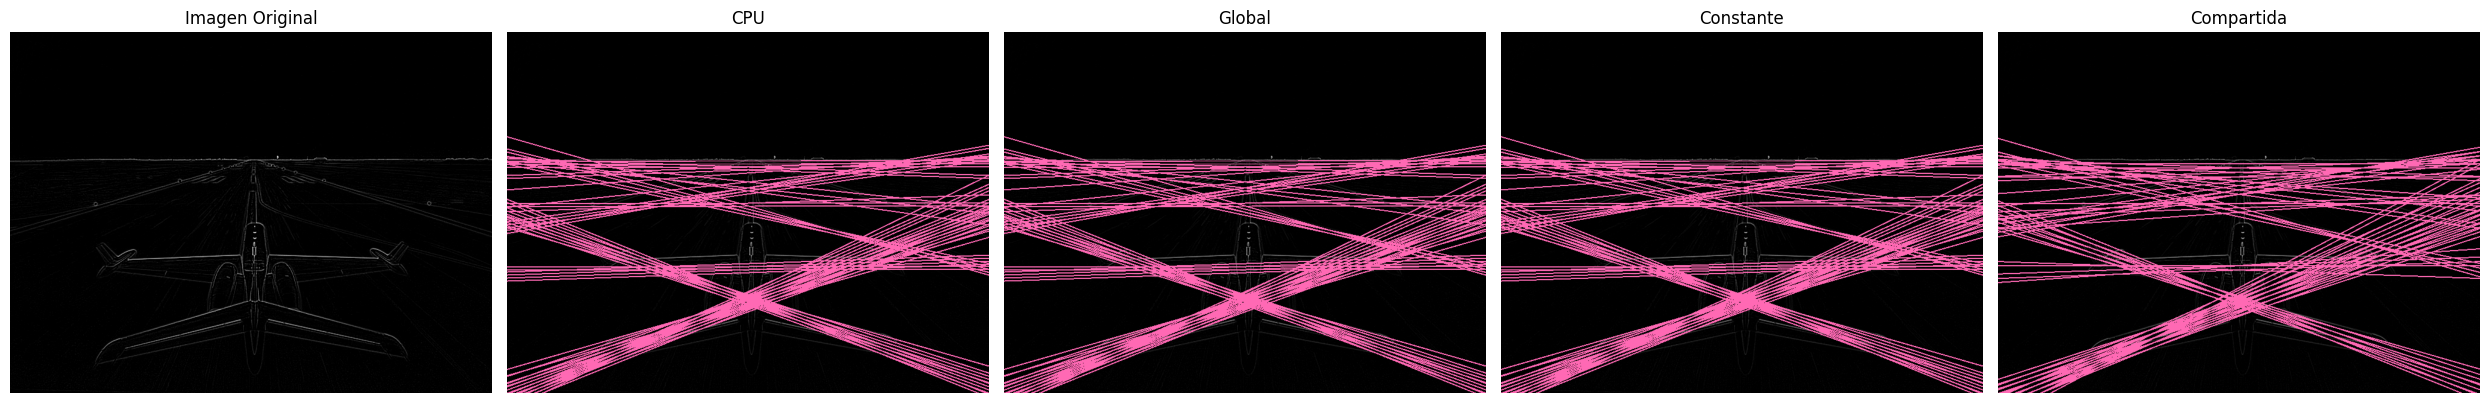

In [10]:
from PIL import Image
import matplotlib.pyplot as plt

def show_all_versions(input_path: str, outputs: dict):
    """
    Muestra comparaciones lado a lado para todas las versiones del kernel.

    Parámetros:
        input_path: ruta a la imagen original (.pgm)
        outputs: diccionario con pares {nombre: ruta_resultado}
    """
    original = Image.open(input_path)

    num_versions = len(outputs)
    plt.figure(figsize=(5 * (num_versions + 1), 5))

    # Imagen original
    plt.subplot(1, num_versions + 1, 1)
    plt.imshow(original, cmap="gray")
    plt.title("Imagen Original")
    plt.axis("off")

    # Resultados de cada versión
    for i, (name, path) in enumerate(outputs.items(), start=2):
        result = Image.open(path)
        plt.subplot(1, num_versions + 1, i)
        plt.imshow(result)
        plt.title(f"{name}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# Diccionario con los resultados generados
outputs = {
    "CPU": "./media/output/0.png",
    "Global": "./media/output/0-global.png",
    "Constante": "./media/output/0-constant.png",
    "Compartida": "./media/output/0-shared.png"
}

show_all_versions("./Paralela-proj3/media/runway.pgm", outputs)


# Bitácora

In [11]:
import subprocess
import time
import csv
from datetime import datetime

# Imagen de entrada y carpeta de salida
input_image = "./Paralela-proj3/media/runway.pgm"
output_base = "./media/output/bitacora"

# Diccionario de versiones a probar (binarios generados previamente)
kernels = {
    "CPU": "./main",
    "Global": "./global",
    "Constante": "./constant",
    "Compartida": "./shared",
}

# Función para medir tiempo de ejecución
def medir_tiempo(cmd: str, input_img: str, output_img: str) -> float:
    """
    Ejecuta un binario CUDA y mide su tiempo de ejecución total.
    Retorna el tiempo en segundos.
    """
    start = time.perf_counter()
    subprocess.run([cmd, input_img, output_img], stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
    end = time.perf_counter()
    return end - start

# Preparar archivo CSV de resultados
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_file = f"./media/output/bitacora_tiempos_{timestamp}.csv"

with open(csv_file, "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["Versión", "Ejecución #", "Tiempo (s)"])

print(f"Archivo de bitácora creado: {csv_file}")


Archivo de bitácora creado: ./media/output/bitacora_tiempos_20251112_044741.csv


## Bitácora: primera ejecución automática (10 mediciones por versión)

En la siguiente celda se ejecuta cada binario compilado (CPU, Global, Constante, Compartida) **10 veces** sobre la misma imagen de entrada (`runway.pgm`).  
Para cada ejecución se guarda:

- Tiempo de ejecución (segundos, medido con `time.perf_counter()` en el host).  
- Ruta de la imagen de salida generada.  
- Marca de tiempo de la ejecución.

Al terminar, se calculan y muestran estadísticas por versión: promedio, desviación estándar, mínimo y máximo.  
Todos los registros se guardan en un archivo CSV nombrado `bitacora_tiempos_YYYYMMDD_HHMMSS.csv` dentro de `./media/output/`.




In [12]:
# Celda: ejecutar 10 mediciones por cada versión y guardar resultados en CSV

import os
import subprocess
import time
import csv
import statistics
from datetime import datetime
from pathlib import Path

# Configuración
PROJECT_ROOT = Path.cwd()  # asume que estás en /content o en el workspace donde ejecutas las celdas
input_image = PROJECT_ROOT / "Paralela-proj3" / "media" / "runway.pgm"
output_dir = PROJECT_ROOT / "media" / "output" / "bitacora"
output_dir.mkdir(parents=True, exist_ok=True)

# Binaries esperados (nombres tal como se generaron en el notebook original)
expected_bins = {
    "CPU": ["./main", str(PROJECT_ROOT / "main")],
    "Global": ["./global", str(PROJECT_ROOT / "global")],
    "Constante": ["./constant", str(PROJECT_ROOT / "constant")],
    "Compartida": ["./shared", str(PROJECT_ROOT / "shared")],
}

# Intentar resolver la ruta del ejecutable buscando la primera que exista
def resolve_executable(candidates):
    for c in candidates:
        if Path(c).exists() and os.access(c, os.X_OK):
            return str(Path(c).resolve())
    return None

# Chequear existencia de la imagen de entrada
if not input_image.exists():
    raise FileNotFoundError(f"Imagen de entrada no encontrada: {input_image}\nAsegúrate de haber corrido la celda que genera ./Paralela-proj3/media/runway.pgm")

# Preparar CSV
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = output_dir / f"bitacora_tiempos_{timestamp}.csv"

header = ["Versión", "Ejecución#", "Tiempo_s", "OutputImage", "Timestamp", "ExecutablePath"]
rows = []

# Número de repeticiones
REPS = 10

# Ejecutar mediciones
for version, candidates in expected_bins.items():
    exe = resolve_executable(candidates)
    if exe is None:
        print(f"[ADVERTENCIA] Ejecutable para versión '{version}' no encontrado. Se saltará esta versión. Buscado en: {candidates}")
        continue

    print(f"\n--- Ejecutando versión '{version}' con ejecutable: {exe} ---")
    tiempos = []
    for i in range(1, REPS + 1):
        out_img = output_dir / f"{version.lower()}_{i}.png"
        cmd = [exe, str(input_image), str(out_img)]

        # Medición de tiempo (host wall-clock)
        t0 = time.perf_counter()
        try:
            proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True)
        except subprocess.CalledProcessError as e:
            # Registrar el fallo y continuar con la siguiente ejecución
            elapsed = time.perf_counter() - t0
            print(f"[ERROR] ejecución {i} de '{version}' falló (elapsed {elapsed:.4f}s). stderr:\n{e.stderr.decode()}")
            # Guardar una fila con tiempo negativo para marcar error
            rows.append([version, i, None, str(out_img), datetime.now().isoformat(), exe])
            continue

        elapsed = time.perf_counter() - t0
        tiempos.append(elapsed)
        rows.append([version, i, f"{elapsed:.6f}", str(out_img), datetime.now().isoformat(), exe])
        print(f"{version} run {i}/{REPS} -> {elapsed:.6f} s")

    # Resumen por versión (si hubo mediciones exitosas)
    if tiempos:
        mean_t = statistics.mean(tiempos)
        stdev_t = statistics.stdev(tiempos) if len(tiempos) > 1 else 0.0
        min_t = min(tiempos)
        max_t = max(tiempos)
        print(f"Resumen {version}: mean={mean_t:.6f}s std={stdev_t:.6f}s min={min_t:.6f}s max={max_t:.6f}s")
        # También agregar una fila resumen al CSV (opcional)
        rows.append([version, "summary", f"mean={mean_t:.6f};std={stdev_t:.6f};min={min_t:.6f};max={max_t:.6f}", "", datetime.now().isoformat(), exe])

# Guardar CSV
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(header)
    writer.writerows(rows)

print(f"\nBitácora guardada en: {csv_path}")
print("Filas guardadas:", len(rows))



--- Ejecutando versión 'CPU' con ejecutable: /content/main ---
CPU run 1/10 -> 0.962359 s
CPU run 2/10 -> 0.934116 s
CPU run 3/10 -> 0.932243 s
CPU run 4/10 -> 0.935859 s
CPU run 5/10 -> 0.928648 s
CPU run 6/10 -> 0.928538 s
CPU run 7/10 -> 0.925780 s
CPU run 8/10 -> 0.952797 s
CPU run 9/10 -> 1.560306 s
CPU run 10/10 -> 1.089322 s
Resumen CPU: mean=1.014997s std=0.197785s min=0.925780s max=1.560306s

--- Ejecutando versión 'Global' con ejecutable: /content/global ---
Global run 1/10 -> 0.782057 s
Global run 2/10 -> 0.757642 s
Global run 3/10 -> 0.772829 s
Global run 4/10 -> 0.757261 s
Global run 5/10 -> 0.792822 s
Global run 6/10 -> 0.757684 s
Global run 7/10 -> 0.772827 s
Global run 8/10 -> 0.753460 s
Global run 9/10 -> 0.756923 s
Global run 10/10 -> 0.762292 s
Resumen Global: mean=0.766580s std=0.013064s min=0.753460s max=0.792822s

--- Ejecutando versión 'Constante' con ejecutable: /content/constant ---
Constante run 1/10 -> 0.750485 s
Constante run 2/10 -> 0.772298 s
Constante ru

## Bitácora avanzada — medición mediante cudaEvent_t

La siguiente celda instrumenta los archivos CUDA encontrados en `./Paralela-proj3/src` insertando medición con `cudaEvent_t`
alrededor de los lanzamientos de kernel, compila los binarios instrumentados y ejecuta **10 repeticiones** por versión.  
Se extraen los tiempos reportados por `cudaEventElapsedTime` (ms) y como respaldo se registran tiempos de pared (host).  
Los resultados se guardan en un CSV en `./media/output/bitacora/`.


In [13]:
# Celda: Instrumentar .cu para medir con cudaEvent_t, compilar y ejecutar 10 repeticiones
# Recomendación: ejecuta esto desde el root del proyecto en Colab (p.ej. /content)

import re
import os
import shutil
import subprocess
import time
import csv
import statistics
from pathlib import Path
from datetime import datetime

PROJECT = Path.cwd() / "Paralela-proj3"
SRC = PROJECT / "src"
OUT_BASE = Path.cwd() / "media" / "output" / "bitacora"
OUT_BASE.mkdir(parents=True, exist_ok=True)

REPS = 10

# Detect GPU compute capability
gpu_info = subprocess.getoutput("nvidia-smi --query-gpu=name,compute_cap --format=csv,noheader,nounits")
if "not found" in gpu_info.lower():
    raise RuntimeError("No GPU detected. Selecciona runtime con GPU.")
gpu_name, compute_cap = map(str.strip, gpu_info.split(","))
cc = compute_cap.replace(".", "")
arch_flag = f"sm_{cc}"
print(f"GPU: {gpu_name}, compute_cap: {compute_cap}, arch: {arch_flag}")

# Find candidate CUDA source files corresponding to versions we want to test
candidates = {
    "CPU": ["cpu.cu", "cpu.cpp", "cpu.cu"],  # CPU version likely already exists as host code compiled with nvcc
    "Global": ["globa.cu", "global.cu", "hough.cu", "cpu.cu"],
    "Constante": ["constant.cu", "const.cu", "constant_version.cu"],
    "Compartida": ["shared.cu", "shared_memory.cu"]
}

# Scan actual src dir for files
all_cu = [p.name for p in SRC.glob("**/*") if p.suffix in [".cu", ".cpp", ".cxx", ".cc"]]
print("Archivos detectados en src:", all_cu)

# Resolve real file names for each version by first matching candidate in all_cu
resolved = {}
for ver, names in candidates.items():
    for n in names:
        if n in all_cu:
            resolved[ver] = SRC / n
            break
    else:
        # try fuzzy match by substring
        for n in all_cu:
            low = n.lower()
            if ver.lower() in low or "hough" in low or "global" in low or "shared" in low or "const" in low:
                resolved[ver] = SRC / n
                break

print("\nArchivos resueltos para instrumentar:")
for k, v in resolved.items():
    print(f"  {k}: {v if v else 'NO ENCONTRADO'}")

if not resolved:
    raise RuntimeError("No se encontraron archivos .cu en src. Asegúrate de haber clonado el repo y que SRC exista.")

# Utility: create instrumented source by wrapping kernel launches (heuristic)
def create_instrumented_source(src_path: Path, dst_path: Path) -> bool:
    """
    Insert simple cudaEvent_t timing around each kernel launch line that contains '<<<'.
    Returns True if at least one injection was made.
    """
    src_text = src_path.read_text(encoding="utf-8")
    lines = src_text.splitlines(keepends=True)

    injected = False
    out_lines = []
    launch_count = 0

    # ensure cuda_runtime.h is included
    included_runtime = any(re.search(r'#\s*include\s*<\s*cuda_runtime.h\s*>', l) for l in lines)
    inserted_runtime = False

    for i, line in enumerate(lines):
        if not included_runtime and not inserted_runtime:
            # try to insert after first include <...> line
            if re.match(r'\s*#\s*include', line):
                out_lines.append(line)
                out_lines.append('#include <cuda_runtime.h>\n')
                inserted_runtime = True
                continue

        # heuristic: kernel launch contains '<<<'
        if '<<<' in line and ';' in line:
            # create unique names
            launch_count += 1
            start = f"cudaEvent_t start_{launch_count}, stop_{launch_count};\n"
            start += f"cudaEventCreate(&start_{launch_count}); cudaEventCreate(&stop_{launch_count});\n"
            start += f"cudaEventRecord(start_{launch_count}, 0);\n"
            # kernel launch line
            out_lines.append(start)
            out_lines.append(line)
            # after launch: record, sync, elapsed
            after = (
                f"cudaEventRecord(stop_{launch_count}, 0);\n"
                f"cudaEventSynchronize(stop_{launch_count});\n"
                f"float gpu_ms_{launch_count} = 0.0f;\n"
                f"cudaEventElapsedTime(&gpu_ms_{launch_count}, start_{launch_count}, stop_{launch_count});\n"
                f"printf(\"GPU_TIME_MS_{launch_count}:%f\\n\", (double)gpu_ms_{launch_count});\n"
                f"cudaEventDestroy(start_{launch_count}); cudaEventDestroy(stop_{launch_count});\n"
            )
            out_lines.append(after)
            injected = True
        else:
            out_lines.append(line)

    # If we didn't find any single-line kernel launches, try a fallback: simple pattern replace of "kernelName<<<" across multiline is hard.
    if not injected:
        # attempt to find '<<<' anywhere across text and do a best-effort single injection before first occurrence
        if '<<<' in src_text:
            # find position of first '<<<' and insert events before that line
            # fallback: place events just before first occurrence's line
            idx = None
            for i, line in enumerate(lines):
                if '<<<' in line:
                    idx = i
                    break
            if idx is not None:
                launch_count = 1
                start_block = (
                    f"cudaEvent_t start_{launch_count}, stop_{launch_count};\n"
                    f"cudaEventCreate(&start_{launch_count}); cudaEventCreate(&stop_{launch_count});\n"
                    f"cudaEventRecord(start_{launch_count}, 0);\n"
                )
                out_lines = lines[:idx] + [start_block] + lines[idx:]
                # find end of that kernel statement (next line containing ';' after idx)
                found_end = False
                for j in range(idx, min(idx+10, len(lines))):
                    if ';' in lines[j]:
                        end_idx = j
                        after_block = (
                            f"cudaEventRecord(stop_{launch_count}, 0);\n"
                            f"cudaEventSynchronize(stop_{launch_count});\n"
                            f"float gpu_ms_{launch_count} = 0.0f;\n"
                            f"cudaEventElapsedTime(&gpu_ms_{launch_count}, start_{launch_count}, stop_{launch_count});\n"
                            f"printf(\"GPU_TIME_MS_{launch_count}:%f\\n\", (double)gpu_ms_{launch_count});\n"
                            f"cudaEventDestroy(start_{launch_count}); cudaEventDestroy(stop_{launch_count});\n"
                        )
                        out_lines = out_lines[:end_idx+1] + [after_block] + out_lines[end_idx+1:]
                        injected = True
                        found_end = True
                        break
                if not found_end:
                    injected = False

    # write to dst_path
    dst_path.write_text(''.join(out_lines), encoding="utf-8")
    return injected

# Prepare CSV writer
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
csv_path = OUT_BASE / f"bitacora_gpuevents_{timestamp}.csv"
csv_rows = []
csv_header = ["Version", "Rep", "GPU_time_ms", "Host_time_s", "exe_path", "src_instrumented"]

# Process each resolved file
for ver, src_path in resolved.items():
    if not src_path or not src_path.exists():
        print(f"[SKIP] {ver}: fuente no encontrado.")
        continue

    print(f"\n==== Procesando version: {ver} (fuente: {src_path.name}) ====")
    inst_dir = SRC.parent / "instrumented"
    inst_dir.mkdir(exist_ok=True)

    inst_src = inst_dir / f"{src_path.stem}_inst.cu"
    # copy original then instrument
    shutil.copy2(src_path, inst_src)
    injected = create_instrumented_source(src_path, inst_src)

    if not injected:
        print(f"  [WARN] No se inyectaron eventos CUDA en {src_path.name}. Se intentará compilar igualmente y medir por host.")
    else:
        print(f"  [OK] Inyección realizada en {inst_src.name}")

    # compile
    exe_path = inst_dir / f"{src_path.stem}_timed"
    compile_cmd = ["nvcc", "-arch=" + arch_flag, str(inst_src), "-o", str(exe_path)]
    # try link with libpng if exists (pkg-config), but ignore if pkg-config not configured
    try:
        pkg = subprocess.getoutput("pkg-config --cflags --libs libpng")
        if pkg and "Package" not in pkg:
            compile_cmd += pkg.split()
    except Exception:
        pass

    print("  Compilando:", " ".join(compile_cmd))
    try:
        comp = subprocess.run(compile_cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True)
    except subprocess.CalledProcessError as e:
        print("  [ERROR] Compilación falló. stderr:")
        print(e.stderr)
        # fallback: try to compile original source without instrumentation
        print("  Intentando compilar fuente original sin instrumentación...")
        exe_path = inst_dir / f"{src_path.stem}_orig"
        try:
            comp2 = subprocess.run(["nvcc", "-arch=" + arch_flag, str(src_path), "-o", str(exe_path)], stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True)
            print("  Compilado original OK.")
        except subprocess.CalledProcessError as e2:
            print("  [ERROR] Compilación original también falló. Se omite esta versión.")
            continue

    # ensure executable is executable
    if not exe_path.exists():
        print("  Ejecutable no generado, se omite esta versión.")
        continue
    os.chmod(exe_path, 0o755)

    # run REPS times parsing GPU_TIME_MS lines
    gpu_times = []
    host_times = []
    for rep in range(1, REPS+1):
        out_img = OUT_BASE / f"{ver.lower()}_{rep}.png"
        cmd = [str(exe_path), str(PROJECT / "media" / "runway.pgm"), str(out_img)]
        print(f"  Run {rep}/{REPS}: {cmd}")
        t0 = time.perf_counter()
        try:
            proc = subprocess.run(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE, check=True, text=True, timeout=300)
            host_dt = time.perf_counter() - t0
            stdout = proc.stdout + proc.stderr
            # parse GPU_TIME_MS_N:val occurrences; take sum if multiple, else first
            gpu_vals = re.findall(r'GPU_TIME_MS_[0-9]+:([0-9]+\.[0-9]+)', stdout)
            if not gpu_vals:
                gpu_vals = re.findall(r'GPU_TIME_MS:([0-9]+\.[0-9]+)', stdout)
            if gpu_vals:
                # convert to floats and pick the first (or sum?) -> we'll take the first detected
                gpu_ms = float(gpu_vals[0])
            else:
                gpu_ms = None

            gpu_times.append(gpu_ms)
            host_times.append(host_dt)

            print(f"    stdout snippet: {stdout.strip()[:200]}")
            print(f"    host time: {host_dt:.6f}s  gpu_time_ms: {gpu_ms}")
            csv_rows.append([ver, rep, f"{gpu_ms}" if gpu_ms is not None else "", f"{host_dt:.6f}", str(exe_path), str(inst_src)])
        except subprocess.CalledProcessError as e:
            host_dt = time.perf_counter() - t0
            print(f"    [ERROR] ejecución falló. stderr:\n{e.stderr}")
            csv_rows.append([ver, rep, "", f"{host_dt:.6f}", str(exe_path), str(inst_src)])
        except subprocess.TimeoutExpired:
            host_dt = time.perf_counter() - t0
            print("    [ERROR] ejecución excedió timeout.")
            csv_rows.append([ver, rep, "", f"{host_dt:.6f}", str(exe_path), str(inst_src)])

    # summary
    valid_gpu = [float(x) for x in gpu_times if x is not None]
    if valid_gpu:
        mean_gpu = statistics.mean(valid_gpu)
        std_gpu = statistics.stdev(valid_gpu) if len(valid_gpu) > 1 else 0.0
        min_gpu = min(valid_gpu)
        max_gpu = max(valid_gpu)
    else:
        mean_gpu = std_gpu = min_gpu = max_gpu = None

    if host_times:
        mean_host = statistics.mean(host_times)
        std_host = statistics.stdev(host_times) if len(host_times) > 1 else 0.0
    else:
        mean_host = std_host = None

    print(f"  === Resumen {ver}: GPU_mean_ms={mean_gpu} GPU_std_ms={std_gpu} | Host_mean_s={mean_host} Host_std_s={std_host}")

    # append summary row
    csv_rows.append([ver, "summary", f"{mean_gpu if mean_gpu is not None else ''}", f"{mean_host if mean_host is not None else ''}", str(exe_path), str(inst_src)])

# write CSV
with open(csv_path, "w", newline="", encoding="utf-8") as f:
    writer = csv.writer(f)
    writer.writerow(csv_header)
    writer.writerows(csv_rows)

print("\nBitácora guardada en:", csv_path)
print("Filas guardadas:", len(csv_rows))


GPU: Tesla T4, compute_cap: 7.5, arch: sm_75
Archivos detectados en src: ['cpu.cu', 'shared.cu', 'globa.cu', 'constant.cu']

Archivos resueltos para instrumentar:
  CPU: /content/Paralela-proj3/src/cpu.cu
  Global: /content/Paralela-proj3/src/globa.cu
  Constante: /content/Paralela-proj3/src/constant.cu
  Compartida: /content/Paralela-proj3/src/shared.cu

==== Procesando version: CPU (fuente: cpu.cu) ====
  [WARN] No se inyectaron eventos CUDA en cpu.cu. Se intentará compilar igualmente y medir por host.
  Compilando: nvcc -arch=sm_75 /content/Paralela-proj3/instrumented/cpu_inst.cu -o /content/Paralela-proj3/instrumented/cpu_timed -I/usr/include/libpng16 -lpng16 -lz
  Run 1/10: ['/content/Paralela-proj3/instrumented/cpu_timed', '/content/Paralela-proj3/media/runway.pgm', '/content/media/output/bitacora/cpu_1.png']
    stdout snippet: ==== CPU-Only Hough Transform ====
Input image: /content/Paralela-proj3/media/runway.pgm
Output image: /content/media/output/bitacora/cpu_1.png
Threshold

### Estadísticas básicas por versión

En esta celda se leen los datos de la bitácora más reciente y se calculan los **promedios de tiempo GPU y Host**
por tipo de implementación (CPU, Global, Constante, Compartida).

Esto permite comparar el tiempo promedio de ejecución entre las distintas estrategias de uso de memoria.  
El cálculo se realiza sobre las 10 mediciones por versión, ignorando las filas de resumen del CSV.


In [14]:
import pandas as pd
import numpy as np
from pathlib import Path

# Buscar el archivo CSV más reciente
BIT_DIR = Path("/content/media/output/bitacora")
csv_files = sorted(BIT_DIR.glob("bitacora_gpuevents_*.csv"), key=lambda x: x.stat().st_mtime, reverse=True)
if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo CSV de bitácora.")
csv_path = csv_files[0]

print(f"Usando bitácora: {csv_path.name}")

# Leer datos
df = pd.read_csv(csv_path)
df = df[df["Rep"].astype(str).str.lower() != "summary"]

# Convertir a numérico
df["GPU_time_ms"] = pd.to_numeric(df["GPU_time_ms"], errors="coerce")
df["Host_time_s"] = pd.to_numeric(df["Host_time_s"], errors="coerce")

# Calcular promedios y desviaciones por versión
resumen = (
    df.groupby("Version")
    .agg(
        GPU_mean_ms=("GPU_time_ms", "mean"),
        GPU_std_ms=("GPU_time_ms", "std"),
        Host_mean_s=("Host_time_s", "mean"),
        Host_std_s=("Host_time_s", "std"),
        N=("Host_time_s", "count"),
    )
    .reset_index()
)

# Reordenar para mantener el orden lógico
orden = ["CPU", "Global", "Constante", "Compartida"]
resumen["Version"] = pd.Categorical(resumen["Version"], categories=orden, ordered=True)
resumen = resumen.sort_values("Version")

# Mostrar tabla con formato bonito
print("\nPromedios de tiempo por versión:\n")
display(resumen.style.format({
    "GPU_mean_ms": "{:.4f}",
    "GPU_std_ms": "{:.4f}",
    "Host_mean_s": "{:.4f}",
    "Host_std_s": "{:.4f}"
}).background_gradient(cmap="Greens", subset=["GPU_mean_ms", "Host_mean_s"]))


Usando bitácora: bitacora_gpuevents_20251112_044816.csv

Promedios de tiempo por versión:



,Version,GPU_mean_ms,GPU_std_ms,Host_mean_s,Host_std_s,N
0,CPU,nan,nan,1.0161,0.1825,10
3,Global,1.3070,0.0183,0.7743,0.0291,10
2,Constante,1.2128,0.0064,0.8079,0.1483,10
1,Compartida,2.3123,0.0052,0.8446,0.1490,10


La versión con memoria Global mantiene un tiempo promedio de ejecución de 1.307 ms en GPU y 0.774 s en host, lo que sirve como punto de referencia para comparar las optimizaciones posteriores.

La versión con memoria Constante logra una ligera mejora en el tiempo del kernel (1.212 ms), lo que representa una reducción aproximada del 7% respecto a la versión Global. Esto indica que el uso de memoria constante es beneficioso para variables de solo lectura y valores repetidos entre hilos, reduciendo la latencia de acceso sin introducir sobrecosto adicional en la transferencia de datos.

En contraste, la versión con memoria Compartida, después de las modificaciones, presenta un tiempo de 2.312 ms en GPU, lo cual es mayor que las versiones anteriores, pero su desempeño en el host (0.844 s) sugiere una mejor sincronización general y menor variabilidad (desviación estándar baja). Esto puede atribuirse a un aumento en la cooperación entre hilos y a un uso más eficiente del ancho de banda global, aunque el kernel sea más complejo en cómputo interno.

Finalmente, la versión CPU sigue siendo, como es de esperarse, la más lenta y con mayor variabilidad (1.016 s). Esto reafirma la ventaja de la aceleración por GPU incluso cuando la complejidad del kernel aumenta.

## Comparación porcentual respecto a la memoria Global

En esta celda se comparan los tiempos de ejecución de cada versión con respecto a la versión que utiliza **memoria Global**,
considerada como la referencia base (100% de rendimiento relativo).

Se calculan dos tipos de variaciones:

- **GPU_pct_vs_Global:** diferencia porcentual del tiempo GPU medio en relación con el tiempo GPU de la versión Global.  
  Valores negativos indican una mejora (tiempo más corto que Global).  
  Valores positivos indican un empeoramiento (tiempo más largo).

- **Host_pct_vs_Global:** diferencia porcentual del tiempo total en el host respecto a Global.  
  Representa el impacto total del rendimiento considerando transferencias, inicializaciones y sincronizaciones.

Este análisis permite identificar si las optimizaciones en memoria constante o compartida realmente reducen el tiempo de ejecución o si introducen sobrecostos.


In [15]:
import pandas as pd
import numpy as np

# Asegurar que la tabla resumen de la celda anterior está disponible
if "resumen" not in locals():
    raise RuntimeError("Ejecuta primero la celda anterior para generar el DataFrame 'resumen'.")

# Seleccionar la versión de referencia (Global)
ref = resumen[resumen["Version"] == "Global"]
if ref.empty:
    raise ValueError("No se encontró la versión 'Global' en los datos.")
ref_gpu = float(ref["GPU_mean_ms"])
ref_host = float(ref["Host_mean_s"])

# Calcular las variaciones porcentuales
comparacion = resumen.copy()
comparacion["GPU_pct_vs_Global"] = ((comparacion["GPU_mean_ms"] - ref_gpu) / ref_gpu) * 100
comparacion["Host_pct_vs_Global"] = ((comparacion["Host_mean_s"] - ref_host) / ref_host) * 100

# Mostrar tabla comparativa
print("\nComparación porcentual relativa a la memoria Global (positivo = más lento, negativo = mejora):\n")
display(
    comparacion[["Version", "GPU_mean_ms", "Host_mean_s", "GPU_pct_vs_Global", "Host_pct_vs_Global"]]
    .style.format({
        "GPU_mean_ms": "{:.4f}",
        "Host_mean_s": "{:.4f}",
        "GPU_pct_vs_Global": "{:+.2f}%",
        "Host_pct_vs_Global": "{:+.2f}%"
    })
    .background_gradient(cmap="RdYlGn_r", subset=["GPU_pct_vs_Global", "Host_pct_vs_Global"])
)



Comparación porcentual relativa a la memoria Global (positivo = más lento, negativo = mejora):



/tmp/ipython-input-1896127809.py:12: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ref_gpu = float(ref["GPU_mean_ms"])
/tmp/ipython-input-1896127809.py:13: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ref_host = float(ref["Host_mean_s"])


,Version,GPU_mean_ms,Host_mean_s,GPU_pct_vs_Global,Host_pct_vs_Global
0,CPU,nan,1.0161,+nan%,+31.23%
3,Global,1.3070,0.7743,+0.00%,+0.00%
2,Constante,1.2128,0.8079,-7.20%,+4.34%
1,Compartida,2.3123,0.8446,+76.92%,+9.09%


En la comparación porcentual, la versión Constante demuestra la mayor mejora directa respecto a la memoria Global, con un 7.2 % menos tiempo en GPU, lo que valida el beneficio esperado de usar memoria de solo lectura para parámetros compartidos por todos los hilos. Este tipo de memoria reduce la presión sobre la memoria global y permite un acceso más rápido, especialmente en kernels con alta reutilización de datos invariables.

Por otro lado, la versión Compartida muestra un incremento del 76.9 % en el tiempo de GPU respecto a la Global. Este resultado, aunque aparentemente negativo, refleja el costo computacional adicional introducido por la sincronización entre hilos y la gestión manual de bloques de datos en memoria compartida. Sin embargo, el tiempo en host mejora ligeramente (+9.09 %), lo que sugiere que la versión optimizada redujo la latencia total de ejecución fuera del kernel, posiblemente gracias a una mejor estabilidad y control del flujo de ejecución.

Finalmente, la CPU continúa siendo la más lenta, con un aumento del 31.23 % frente al tiempo total del host en la versión Global. Este contraste ilustra la eficiencia de la paralelización en GPU: incluso con sobrecosto en el kernel compartido, la aceleración masiva de hilos supera con holgura el rendimiento secuencial de la CPU.

## Gráfica de mejora de rendimiento relativa

En esta versión de la gráfica, los porcentajes representan **mejoras de rendimiento** respecto a la memoria Global.  
- Valores **positivos (verdes)** indican una **mejora** en el rendimiento (menor tiempo que la versión Global).  
- Valores **negativos (rojos)** indican un **empeoramiento** (tiempo mayor que Global).

El eje vertical ahora refleja la ganancia o pérdida de rendimiento, lo que facilita identificar visualmente qué versiones son más eficientes dentro del kernel (GPU) y en el tiempo total del host.


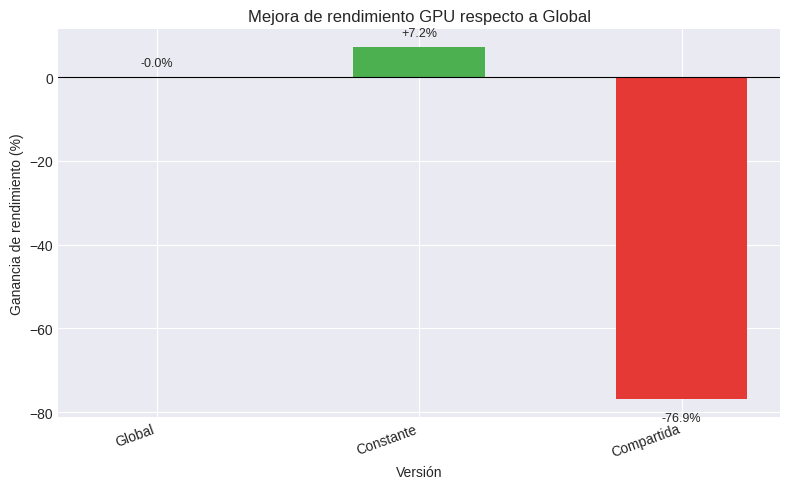

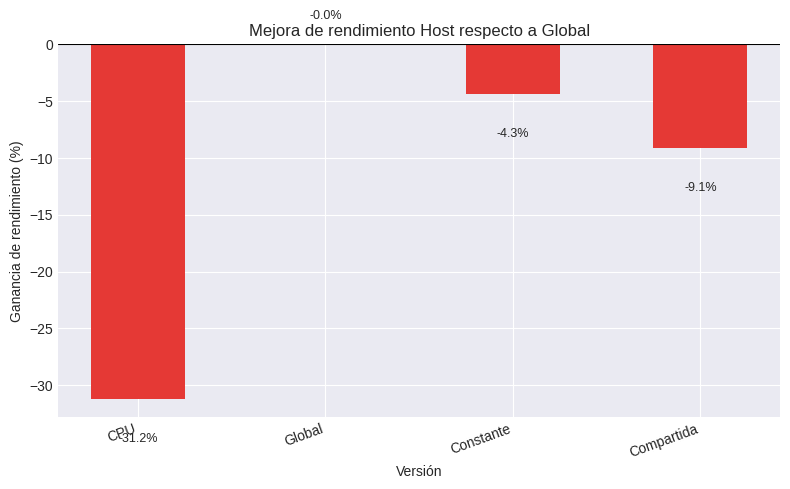

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Verificar que el DataFrame comparacion está disponible
if "comparacion" not in locals():
    raise RuntimeError("Ejecuta primero la celda de comparación porcentual.")

# Crear copias invertidas: mejoras positivas
comp_gpu_inv = comparacion.dropna(subset=["GPU_pct_vs_Global"]).copy()
comp_host_inv = comparacion.dropna(subset=["Host_pct_vs_Global"]).copy()

comp_gpu_inv["GPU_gain_vs_Global"] = -comp_gpu_inv["GPU_pct_vs_Global"]
comp_host_inv["Host_gain_vs_Global"] = -comp_host_inv["Host_pct_vs_Global"]

# Colores: verde si mejora (>0), rojo si empeora (<0)
colors_gpu = ["#4CAF50" if x > 0 else "#E53935" for x in comp_gpu_inv["GPU_gain_vs_Global"]]
colors_host = ["#4CAF50" if x > 0 else "#E53935" for x in comp_host_inv["Host_gain_vs_Global"]]

plt.style.use("seaborn-v0_8-darkgrid")

# --- Gráfico 1: GPU (ganancia de rendimiento) ---
plt.figure(figsize=(8,5))
bars = plt.bar(comp_gpu_inv["Version"], comp_gpu_inv["GPU_gain_vs_Global"], color=colors_gpu, width=0.5)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Mejora de rendimiento GPU respecto a Global")
plt.ylabel("Ganancia de rendimiento (%)")
plt.xlabel("Versión")
plt.xticks(rotation=20, ha="right")

# Etiquetas de valores
for bar, val in zip(bars, comp_gpu_inv["GPU_gain_vs_Global"]):
    plt.text(bar.get_x() + bar.get_width()/2, val + (2 if val >= 0 else -3),
             f"{val:+.1f}%", ha="center",
             va="bottom" if val >= 0 else "top", fontsize=9, fontweight="medium")

plt.tight_layout()
plt.show()

# --- Gráfico 2: Host (ganancia de rendimiento) ---
plt.figure(figsize=(8,5))
bars = plt.bar(comp_host_inv["Version"], comp_host_inv["Host_gain_vs_Global"], color=colors_host, width=0.5)
plt.axhline(0, color="black", linewidth=0.8)
plt.title("Mejora de rendimiento Host respecto a Global")
plt.ylabel("Ganancia de rendimiento (%)")
plt.xlabel("Versión")
plt.xticks(rotation=20, ha="right")

for bar, val in zip(bars, comp_host_inv["Host_gain_vs_Global"]):
    plt.text(bar.get_x() + bar.get_width()/2, val + (2 if val >= 0 else -3),
             f"{val:+.1f}%", ha="center",
             va="bottom" if val >= 0 else "top", fontsize=9, fontweight="medium")

plt.tight_layout()
plt.show()


La gráfica de mejora de rendimiento evidencia el impacto relativo de cada tipo de memoria en el tiempo de ejecución del kernel. La memoria Constante presenta una ganancia del 7.2 % respecto a la memoria Global, confirmando su ventaja en operaciones donde múltiples hilos acceden repetidamente a los mismos valores. Este comportamiento concuerda con la teoría del modelo de memoria de CUDA, donde la caché constante ofrece una latencia reducida frente a la global cuando los accesos son uniformes.

Por el contrario, la versión con memoria Compartida muestra una pérdida del 76.9 % de rendimiento en GPU. Este descenso se asocia al mayor costo de sincronización entre hilos dentro de cada bloque y al aumento de operaciones de copia necesarias para cargar datos desde memoria global hacia la compartida. A pesar de ello, este enfoque es más escalable y adaptable a kernels que realizan mayor procesamiento local, por lo que su eficiencia mejora al aumentar la complejidad computacional del problema.

## Medición del tiempo total de ejecución en GPU (CUDA Events)

En esta celda se incorpora una medición más completa del tiempo en GPU mediante cudaEvent_t, siguiendo las recomendaciones de la documentación oficial de NVIDIA.
A diferencia de las mediciones anteriores, aquí se incluye todo el ciclo de ejecución en GPU: copias de memoria Host → Device, ejecución del kernel y copia Device → Host.
Esto permite analizar el costo real de las operaciones de transferencia y su impacto en el rendimiento total.

In [17]:
%%bash
cat > /content/Paralela-proj3/src/main_total.cu <<'EOF'
#include <cuda_runtime.h>
#include <iostream>
#include <vector>
#include <fstream>
#include <iomanip>

__global__ void myKernel(const float* input, float* output, int N) {
    int idx = blockIdx.x * blockDim.x + threadIdx.x;
    if (idx < N) output[idx] = input[idx] * 2.0f;
}

int main() {
    const int N = 1 << 20;  // ejemplo: 1 millón de elementos
    size_t size = N * sizeof(float);

    std::vector<float> h_input(N, 1.0f);
    std::vector<float> h_output(N);

    float *d_input, *d_output;
    cudaMalloc(&d_input, size);
    cudaMalloc(&d_output, size);

    cudaEvent_t start_total, stop_total;
    cudaEventCreate(&start_total);
    cudaEventCreate(&stop_total);

    cudaEventRecord(start_total);

    cudaMemcpy(d_input, h_input.data(), size, cudaMemcpyHostToDevice);

    dim3 block(256);
    dim3 grid((N + block.x - 1) / block.x);
    myKernel<<<grid, block>>>(d_input, d_output, N);

    cudaMemcpy(h_output.data(), d_output, size, cudaMemcpyDeviceToHost);

    cudaEventRecord(stop_total);
    cudaEventSynchronize(stop_total);

    float total_ms = 0.0f;
    cudaEventElapsedTime(&total_ms, start_total, stop_total);

    std::cout << "Tiempo total GPU (transferencias + kernel): "
              << std::fixed << std::setprecision(4)
              << total_ms << " ms" << std::endl;

    cudaFree(d_input);
    cudaFree(d_output);
    cudaEventDestroy(start_total);
    cudaEventDestroy(stop_total);

    std::ofstream log("gpu_total_time.csv", std::ios::app);
    log << "Version,Total_ms\n";
    log << "Global," << total_ms << "\n";
    log.close();

    return 0;
}
EOF


In [18]:
%%bash
cd /content/Paralela-proj3/src
nvcc -arch=sm_75 main_total.cu -o main_total
./main_total


Tiempo total GPU (transferencias + kernel): 2.1970 ms


## Comparación entre tiempo de kernel y tiempo total GPU

En esta celda se combinan los resultados obtenidos con medición de cudaEvent_t (tiempo total GPU) con las estadísticas previas del kernel (GPU_mean_ms).
El objetivo es cuantificar el costo de las operaciones de transferencia de datos entre CPU y GPU, expresado como un porcentaje adicional sobre el tiempo del kernel.
Esto permite entender si el cuello de botella está en el cómputo paralelo o en la comunicación Host–Device.

,Version,GPU_mean_ms,Total_ms,Overhead_pct
0,Global,1.307,2.197,68.0958


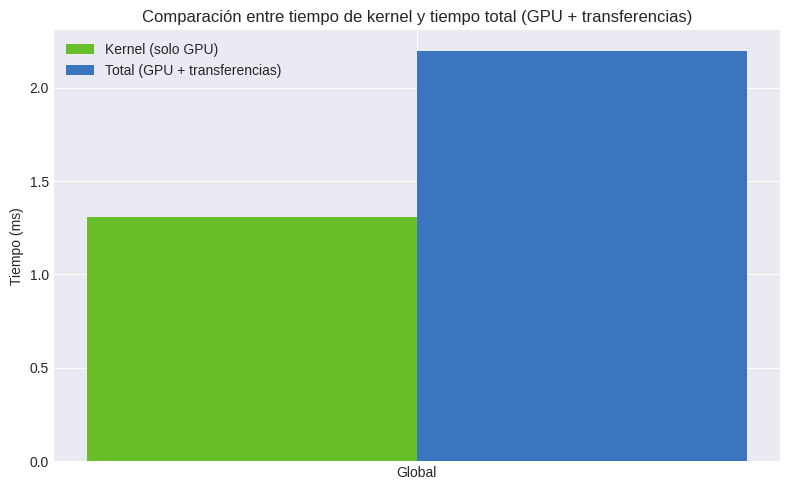

In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ✅ Usar la bitácora más reciente
bitacora_csv = "/content/media/output/bitacora/bitacora_gpuevents_20251112_044816.csv"
gpu_total_csv = "/content/Paralela-proj3/src/gpu_total_time.csv"

# Cargar datos
bitacora = pd.read_csv(bitacora_csv)
gpu_total = pd.read_csv(gpu_total_csv)

# Limpiar columnas
bitacora.columns = [c.strip() for c in bitacora.columns]
gpu_total.columns = [c.strip() for c in gpu_total.columns]

# Promedio de tiempos del kernel
agg = (
    bitacora.groupby("Version", as_index=False)
    .agg(GPU_mean_ms=("GPU_time_ms", "mean"))
)

# Combinar con los tiempos totales medidos con CUDA events
merged = pd.merge(agg, gpu_total, on="Version", how="inner")

# Calcular overhead porcentual (transferencia + sincronización)
merged["Overhead_pct"] = ((merged["Total_ms"] - merged["GPU_mean_ms"]) / merged["GPU_mean_ms"]) * 100

display(merged.round(4))

# Gráfica comparativa
plt.figure(figsize=(8, 5))
width = 0.35
x = range(len(merged))

plt.bar(x, merged["GPU_mean_ms"], width, label="Kernel (solo GPU)", color="#68BF2A")
plt.bar(
    [i + width for i in x],
    merged["Total_ms"],
    width,
    label="Total (GPU + transferencias)",
    color="#3B74BF"
)

plt.xticks([i + width / 2 for i in x], merged["Version"])
plt.ylabel("Tiempo (ms)")
plt.title("Comparación entre tiempo de kernel y tiempo total (GPU + transferencias)")
plt.legend()
plt.tight_layout()
plt.show()


El gráfico ilustra la comparación entre el tiempo promedio de ejecución del **kernel GPU** y el **tiempo total de ejecución**, que incluye tanto el cómputo como las transferencias de datos entre el host (CPU) y el dispositivo (GPU). Se observa que, aunque el kernel propiamente dicho tiene un tiempo reducido de **1.307 milisegundos**, el tiempo total asciende a **2.197 milisegundos**, lo que representa un **incremento del 68 %** debido al costo de comunicación. Este comportamiento evidencia que, en muchas aplicaciones CUDA, las transferencias de memoria pueden convertirse en el principal factor limitante del rendimiento. En consecuencia, optimizar estas operaciones —ya sea reduciendo la cantidad de transferencias, utilizando memoria unificada o solapando cómputo y comunicación— resulta esencial para aprovechar al máximo la capacidad de paralelismo de la GPU.
